In [1]:
import nltk 
import json 
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns 

import time
from tqdm import tqdm

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertModel
from rouge_score import rouge_scorer
from transformers import BertTokenizer, BertModel
import torch

## Modules for data extraction 

In [3]:
# The following section is for reading JSON files

def read_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        return data  

In [4]:
# following function removes samples that are incorrect 
def correct_rationale_dict(ds_dict):
    correct_list = []
    ds_data = ds_dict['data']
    for key in ds_data.keys():
        if len(ds_data[key]) > 1 :
            l = []
            for i in ds_data[key]:
                # this is within the list corresponding to each index in data dictionary
                # i is a dictionary 
                if i['answer'] in i['completion']:
                    l.append(i)
            correct_list.append(l)
    return correct_list

In [5]:
# following function makes a list of list containing all the rationales with multiple reasonings
# each list within this list corresponds to one sample index.
# each list within this list contains multiple dictionaries with same sample_index and different completion_index
def rationale_dict(ds_dict):
    rationale_list = []
    ds_data = ds_dict['data']
    for key in ds_data.keys():
        if len(ds_data[key]) > 1 :
            l = []
            for i in ds_data[key]:
                l.append(i)
            # append the list 
            rationale_list.append(l)
    return rationale_list


In [6]:
# Modifies the list into a list only containing the sample_index, completion_index, reasoning_prompt

def helper(ds_list):
    for i in range(len(ds_list)):
        for j in range(len(ds_list[i])):
            d = dict()
            d2 = ds_list[i][j]
            d['sample_index'] = d2['sample_index']
            d['completion_index'] = d2['completion_index']
            d['reasoning_completion'] = d2['reasoning_completion']
            ds_list[i][j] = d

## Modules for calculating score

### Calculation of BERTscore

The similarity between two sentences is computed as the sum of the cosine similarities between their token embeddings, thereby providing the capability to detect paraphrases.

In [7]:
def calculate_bertscore(text1, text2, tokenizer, model):
    inputs = tokenizer([text1, text2], return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    
    embeddings = outputs.last_hidden_state
    # Calculate cosine similarity between the embeddings of text1 and text2
    similarity = torch.nn.functional.cosine_similarity(embeddings[0], embeddings[1], dim=0).mean().item()
    return similarity


### Calculation of ROGUE score

In [8]:
def calculate_rouge(text1, text2):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL', 'rouge2'], use_stemmer=True)
    scores = scorer.score(text1, text2)
    return scores

### Function for pair-wise score calculation

In [9]:
# the following funtion makes the pairs and calls the score_calculator functioin on each pair
# next it stores it in a data type 

# structure of the data type - a list --> [sample_index, (completion_index1, completion_index2), BERT, ROGUE]

def results(ds_list, res_score):
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased') 
    print("start")
    for i in range(len(ds_list)):
        for r1 in range(0, len(ds_list[i])):
            for r2 in range(r1 + 1, len(ds_list[i])):
                text1 = ds_list[i][r1]['reasoning_completion']
                text2 = ds_list[i][r2]['reasoning_completion']
                
                # calculate scores
                bert_score = calculate_bertscore(text1, text2, bert_tokenizer, bert_model)
                
                # rouge score
                rouge_score = calculate_rouge(text1, text2)
                
                # inserting values
                result = dict()
                result['sample_index'] = i
                result['c1'] = ds_list[i][r1]['completion_index']
                result['c2'] = ds_list[i][r2]['completion_index']
                result['bert_score'] = bert_score
                result['rouge_score'] = rouge_score
                
                res_score.append(result)
        # checks
        if i%50 == 0:
            print(i)
        

### Converting results to a tabular form 

In [27]:
# the following function makes a dataframe out of a list 
# the ROUGE1, ROUGE2, ROUGE-L columns contain the fmeasure of the respective quantities 
def tabularForm(ds_list):
    table = pd.DataFrame(ds_list)
    table['ROUGE1'] = 0
    table['ROUGE-L'] = 0
    table['ROUGE2'] = 0
    table['BERT'] = 0
    for i in range(len(ds_list)):
        # i is an int 
        rouge_score = ds_list[i]['rouge_score']           # rouge_score is a dictionary 
        table.loc[i,'ROUGE1'] = rouge_score['rouge1'].fmeasure
        table.loc[i,'ROUGE-L'] = rouge_score['rougeL'].fmeasure
        table.loc[i,'ROUGE2'] = rouge_score['rouge2'].fmeasure
        table.loc[i,'BERT'] = ds_list[i]['bert_score']
        
    return table

The following function removes incorrect samples 

### Visualisation 

###### Box Plot

In [11]:
# box plots for ROUGE scores
def boxPlot(df, colour):
    # Create subplots
    fig, axs = plt.pyplot.subplots(1, 3, figsize=(15, 5))

    sns.boxplot(y=df['ROUGE1'], ax=axs[0], color=colour)
    axs[0].set_title('ROUGE1')
    axs[0].set_ylim(0, 1)

    sns.boxplot(y=df['ROUGE2'], ax=axs[1], color=colour)
    axs[1].set_title('ROUGE2')
    axs[1].set_ylim(0, 1)

    sns.boxplot(y=df['ROUGE-L'], ax=axs[2], color=colour)
    axs[2].set_title('ROUGE-L')
    axs[2].set_ylim(0, 1)

    # Add an overall title to the figure
    fig.suptitle('Box Plots of ROUGE Scores')

    #plt.pyplot.tight_layout()
    plt.pyplot.show()


##### Min Max Median

In [12]:
def format_statistics(series):
    min_value = series.min()
    max_value = series.max()
    median_value = series.median()
    q1_value = series.quantile(0.25)
    q3_value = series.quantile(0.75)
    return f"Min: {min_value:.2f}, Max: {max_value:.2f}, Median: {median_value:.2f}, Q1: {q1_value:.2f}, Q3: {q3_value:.2f}"

# Calculating results 

For the calculation of results we will be using only the datasets that have samples generated with sampling temperature = 0.7 to test the hypothesis.


##### Following datasets give the highest accuracy scores when used on models using Fine Tune Chain-of-Thoughts with diverse reasoning
1. Single Eq (24.34)
2. MultiArith (53.33) (wont work yet)
3. SVAMP (30.33) (wonr work yet)
4. Date Understanding (83.78)
5. Shuffled Objects (73.33)
6. Last Letter Concatenation (62.00)
7. Coin Flip (100.00)

In [13]:
# Loading datasets

"""
1. Addsub
2. Coin flip
3. Date Understanding (incorrect samples included)
4. Last Letter Concatenation (incorrect samples included)
5. MultiArith (incorrect samples included)
6. Single Eq (incorrect samples included)
7. Strategy QA (incorrect samples included)
8. SVAMP (incorrect samples included)
9. Trackling Shuffled Objects (incorrect samples included)
"""

# paths
addsub70_path = '/Users/shiprasingh/IIT KGP internship /reasoning-teacher/saved/teacher_completion_data/B_text-davinci-002__C_zs_cot_t70/D_addsub.json'
coin70_path = '/Users/shiprasingh/IIT KGP internship /reasoning-teacher/saved/teacher_completion_data/B_text-davinci-002__C_zs_cot_t70/D_coin_flip.json'
du70_path = '/Users/shiprasingh/IIT KGP internship /reasoning-teacher/saved/teacher_completion_data/B_text-davinci-002__C_zs_cot_t70/D_date_understanding.json'
llconc70_path = '/Users/shiprasingh/IIT KGP internship /reasoning-teacher/saved/teacher_completion_data/B_text-davinci-002__C_zs_cot_t70/D_last_letter_concatenation.json'
mulAr70_path = '/Users/shiprasingh/IIT KGP internship /reasoning-teacher/saved/teacher_completion_data/B_text-davinci-002__C_zs_cot_t70/D_multiarith.json'
seq70_path = '/Users/shiprasingh/IIT KGP internship /reasoning-teacher/saved/teacher_completion_data/B_text-davinci-002__C_zs_cot_t70/D_single_eq.json'
strat70_path = '/Users/shiprasingh/IIT KGP internship /reasoning-teacher/saved/teacher_completion_data/B_text-davinci-002__C_zs_cot_t70/D_strategy_qa.json'
svamp70_path = '/Users/shiprasingh/IIT KGP internship /reasoning-teacher/saved/teacher_completion_data/B_text-davinci-002__C_zs_cot_t70/D_svamp.json'
tso70_path = '/Users/shiprasingh/IIT KGP internship /reasoning-teacher/saved/teacher_completion_data/B_text-davinci-002__C_zs_cot_t70/D_tracking_shuffled_objects.json'

# Reading JSON data. The read_json() function returns a dictionary
addsub70 = read_json(addsub70_path)
coin70 = read_json(coin70_path)
du70 = read_json(du70_path)
llconc70 = read_json(llconc70_path)
mulAr70 = read_json(mulAr70_path)
seq70 = read_json(seq70_path)
strat70 = read_json(strat70_path)
svamp70 = read_json(svamp70_path)
tso70 = read_json(tso70_path)

In [14]:
# making rationale dictionaries with CORRECT rationales

addsub70_Clist = correct_rationale_dict(addsub70)
coin70_Clist = correct_rationale_dict(coin70)
du70_Clist = correct_rationale_dict(du70)
llconc70_Clist = correct_rationale_dict(llconc70)
mulAr70_Clist = correct_rationale_dict(mulAr70)
seq70_Clist = correct_rationale_dict(seq70)
strat70_Clist = correct_rationale_dict(strat70)
#svamp70_Clist = correct_rationale_dict(svamp70)
tso70_Clist = correct_rationale_dict(tso70)

# modifying lists 

helper(addsub70_Clist)
helper(coin70_Clist)
helper(du70_Clist)
helper(llconc70_Clist)
helper(mulAr70_Clist)
helper(seq70_Clist)
helper(strat70_Clist)
#helper(svamp70_Clist)
helper(tso70_Clist)

### Running code modules 

In [15]:
final_result = dict()
# the following will take much more time while calculating BERT. 

In [16]:
start_time = time.time()

res_score = []
results(addsub70_Clist, res_score)
final_result['AddSub'] = res_score

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

start
0
50
100
150
200
250
Elapsed time: 6.13 seconds


In [17]:
start_time = time.time()

res_score = []
results(coin70_Clist, res_score)
final_result['coin_flip'] = res_score

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

start
0
50
100
150
200
250
300
Elapsed time: 9.54 seconds


In [18]:
start_time = time.time()

res_score = []
results(du70_Clist, res_score)
final_result['date_understanding'] = res_score

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

start
0
50
100
150
200
250
Elapsed time: 15.76 seconds


In [19]:
start_time = time.time()

res_score = []
results(llconc70_Clist, res_score)
final_result['Last_letter_concetenation'] = res_score

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

start
0
50
100
150
200
250
300
Elapsed time: 3.88 seconds


In [20]:
start_time = time.time()

res_score = []
results(seq70_Clist, res_score)
final_result['Single Eq'] = res_score

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

start
0
50
100
150
200
250
300
350
Elapsed time: 2.41 seconds


In [21]:
start_time = time.time()

res_score = []
results(strat70_Clist, res_score)
final_result['Strategy QA'] = res_score

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

start
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
Elapsed time: 0.29 seconds


In [22]:
start_time = time.time()

res_score = []
results(tso70_Clist, res_score)
final_result['Tracking_shuffled_objects'] = res_score

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

start
0
50
100
150
200
250
300
350
400
450
500
Elapsed time: 14.41 seconds


In [23]:
start_time = time.time()

res_score = []
results(strat70_Clist, res_score)
final_result['Strategy QA'] = res_score

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

start
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
Elapsed time: 0.29 seconds


In [24]:
final_result['MultiArith'] = []
final_result['SVAMP'] = []

In [28]:
# converting to tables 

addsub70_Ctable = tabularForm(final_result['AddSub'])
coin70_Ctable = tabularForm(final_result['coin_flip'])
du70_Ctable = tabularForm(final_result['date_understanding'])
llconc70_Ctable = tabularForm(final_result['Last_letter_concetenation'])
# mulAr70_Ctable = tabularForm(final_result['MultiArith'])
seq70_Ctable = tabularForm(final_result['Single Eq'])
strat70_Ctable = tabularForm(final_result['Strategy QA'])
# svamp70_Ctable = tabularForm(final_result['SVAMP'])
tso70_Ctable = tabularForm(final_result['Tracking_shuffled_objects'])

In [30]:
coin70_Ctable.head()

,sample_index,c1,c2,rouge_score,ROUGE1,ROUGE-L,ROUGE2,BERT
0,0,0,1,"{'rouge1': (0.8620689655172413, 0.877192982456...",0.869565,0.869565,0.707965,0
1,0,0,2,"{'rouge1': (0.8620689655172413, 0.877192982456...",0.869565,0.869565,0.707965,0
2,0,0,3,"{'rouge1': (0.9298245614035088, 0.929824561403...",0.929825,0.929825,0.875000,0
3,0,0,4,"{'rouge1': (0.6818181818181818, 0.789473684210...",0.731707,0.682927,0.595041,0
4,0,0,5,"{'rouge1': (0.7931034482758621, 0.807017543859...",0.800000,0.765217,0.637168,0


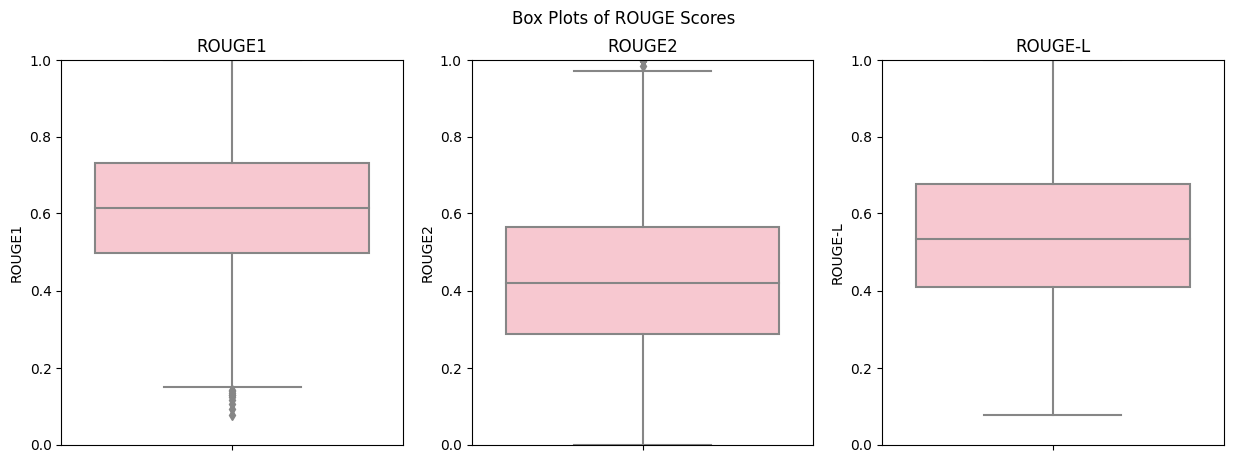

In [34]:
boxPlot(addsub70_Ctable, "pink")

In [41]:
format_statistics(addsub70_Ctable['ROUGE1'])

'Min: 0.08, Max: 1.00, Median: 0.61, Q1: 0.50, Q3: 0.73'

In [42]:
format_statistics(addsub70_Ctable['ROUGE2'])

'Min: 0.00, Max: 1.00, Median: 0.42, Q1: 0.29, Q3: 0.57'

In [40]:
format_statistics(addsub70_Ctable['ROUGE-L'])

'Min: 0.08, Max: 1.00, Median: 0.53, Q1: 0.41, Q3: 0.68'